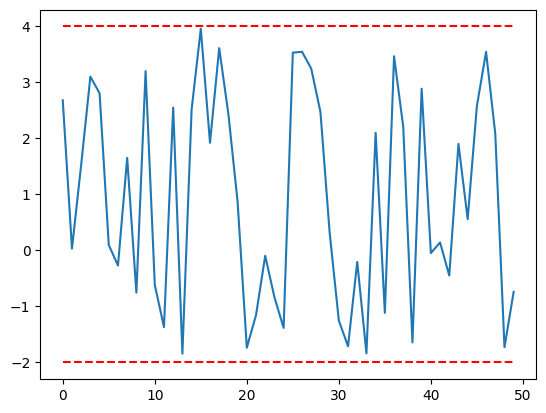

In [33]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange



class Bandit:
    """A bandit with uniform reward distribution."""

    def __init__(self, mean: float, span: float):
        """Initialize the bandit.

        Regardless of the received action, the bandit will return reward
        uniformly sampled from segment [`mean`-`span`, `mean`+`span`].

        Args:
            mean (float): Mean (expected) value of the reward.
            span (float): Span of the reward.
        """
        self.mean = mean
        self.span = span

    def pull_leaver(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        return self.mean + 2*self.span * (random.random()-0.5) # random number in [mean-span, mean+span]

test_mean = 1.0
test_span = 3.0
test_len = 50

test_bandit = Bandit(test_mean, test_span)
test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")




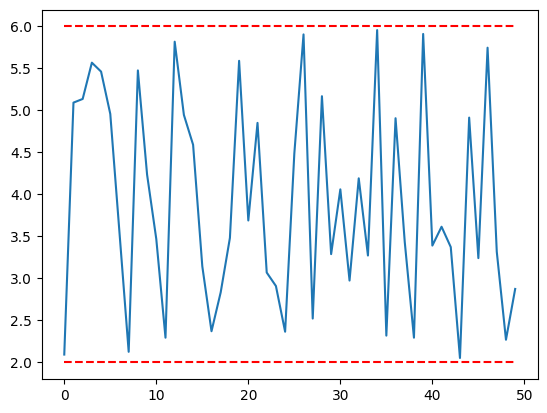

In [34]:
class BanditsEnvironment:
    """An environment consisting of multiple bandits."""

    def __init__(self, bandits: Iterable[Bandit], penalty=1000):
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
            penalty (int, optional):
                If the external agents attempts to use a bandit not in the list,
                i.e. if the chosen action is negative or bigger than the index of
                the last bandit, the returned reward will be `-penalty`. Defaults to 1000.
        """
        self.bandits: list[Bandit] = list(bandits)
        self.penalty = penalty

    def take_action(self, a: int):
        """
        Select bandit `a` and pull its leaver.

        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a<0 or a>=len(self.bandits):
            return -self.penalty
        else:
            return self.bandits[a].pull_leaver()
test_env_size = 5
test_bandits = [Bandit(i**2, i) for i in range(test_env_size)]
test_env = BanditsEnvironment(test_bandits)

selected_bandit = 2
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((selected_bandit**2+selected_bandit)*np.ones(test_len), linestyle="--", color="r")
plt.plot((selected_bandit**2-selected_bandit)*np.ones(test_len), linestyle="--", color="r")


testiranje prosecne nagrade za odredjeni broj random bandita

In [35]:
test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len)]
test_mean = sum(test_rewards)/test_len

print("TEST MEAN = ", test_mean)

TEST MEAN =  5.863315749802523


Definisanje Politike ponasanja agenta

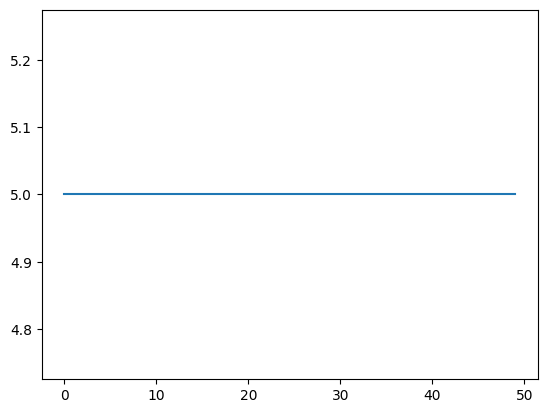

In [36]:
def choose_greedy_action(q):
    return np.argmax(q)

test_q = [1, 2, 3, 2, 1, 5, 4]

test_actions = [choose_greedy_action(test_q) for _ in range(test_len)]

plt.plot(test_actions)

samo bira najveci broj iz niza

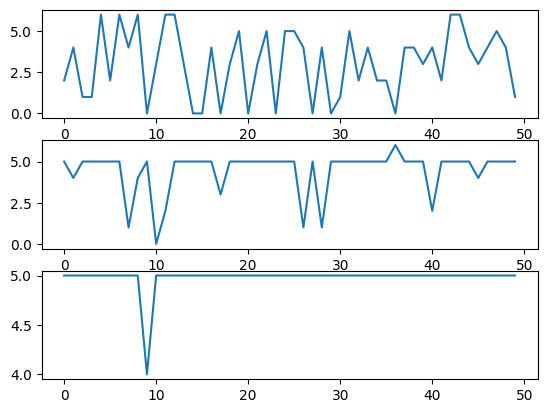

In [37]:
def choose_random_action(n):
    return random.randint(0, n-1)
def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)])

plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)])

plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)])

sto je epsilon manji, vise ce ici greedy, viceversa
epsilon greedy, bira greedy ili random za verovatnocu koju mi kontrolisemo

Potrebno je odraditi trening agenta:

100%|██████████| 5000/5000 [00:00<00:00, 26458.98it/s]


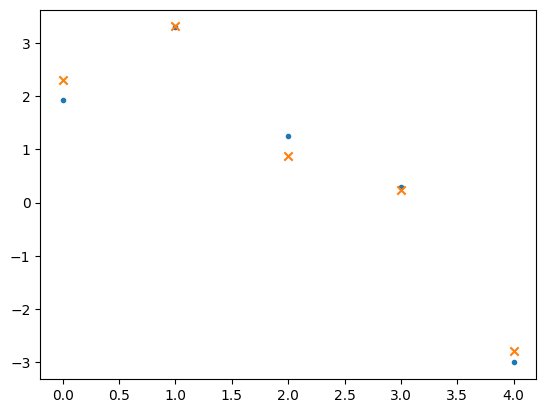

In [38]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)


plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

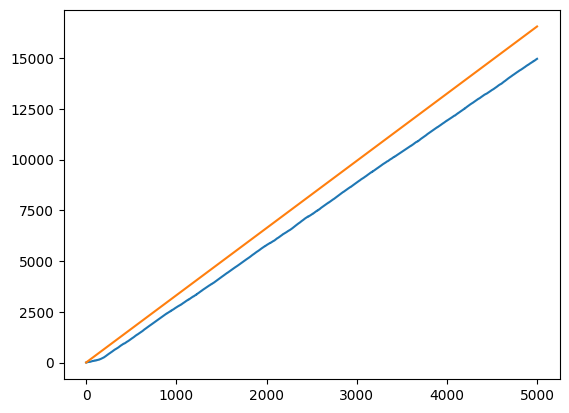

In [39]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))